<a href="https://colab.research.google.com/github/Sal7Duck/rag-ui/blob/code-cleaning/Tokenize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tiktoken
import pickle
import numpy as np
from tqdm.auto import tqdm

In [ ]:
data_dir = "/Users/saloni/Desktop/rag-ui/utilities/final_cleaned_output_text.pkl"
tokenized_text_from_all_dirs = '/Users/saloni/Desktop/rag-ui/utilities/final_tokenized_output_text.pkl'

In [ ]:
tokenizer = tiktoken.get_encoding('cl100k_base')

In [ ]:
#length function
def tiktoken_len(text) :
    tokens = tokenizer.encode (
        text,
        disallowed_special = ()
    )
    return len(tokens)

In [ ]:
with open(data_dir, 'rb') as f:
    all_files = pickle.load(f)

In [ ]:
# Check to see if any file is returning a null object
for key in all_files.keys():
    if key[0:5] not in ['notif', 'rbi_n']:
        print(key)

In [ ]:
# Run it over all the files in the pickle file
with open(data_dir, 'rb') as f:
    all_files = pickle.load(f)

counter = 0
max_tokens = 180000
max_tokens_file = ""

token_counts = []
for key, text in all_files.items() :
    counter += 1
    file_token_len = tiktoken_len(text.strip())
    if file_token_len > max_tokens :
        max_tokens_file = key
    token_counts.append(file_token_len)

print("Total no. of files: ", counter)

# token_counts = []
# for key, text in all_files.items():
#     print(key)
#     print(text[0:5])
#     print("-----")
#     token_counts.append(tiktoken_len(text.strip()))

print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Total no. of files:  33760
Min: 0
Avg: 3167
Max: 197916


In [ ]:
max_tokens_file

'notifications_not_in_toc_114BI010714LA'

In [ ]:
# all_files['notifications_not_in_toc_114BI010714LA']

Total no. of files:  33760
Min: 0
Avg: 3171
Max: 197916

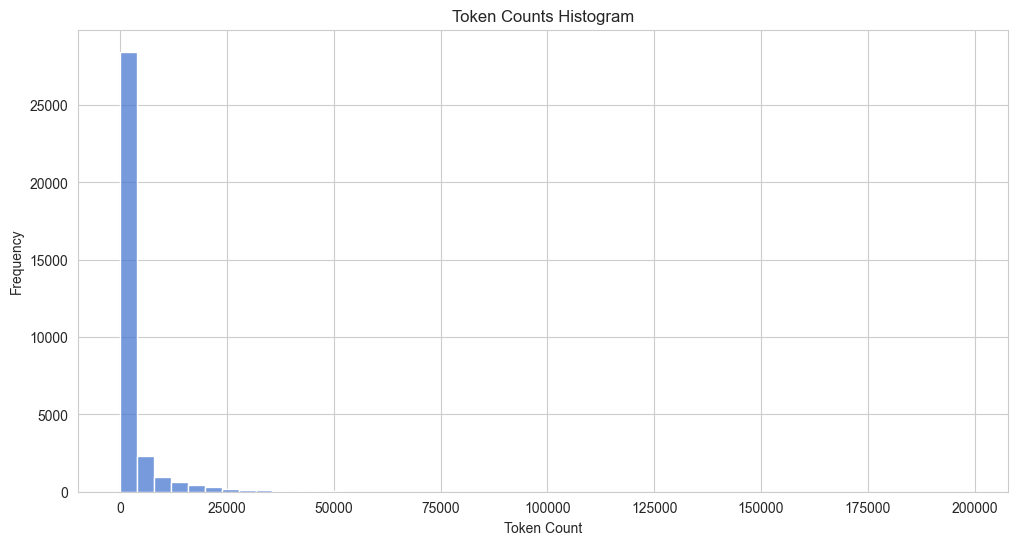

In [ ]:
# visualize distribution of tokens across files
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
# plt.xlim([0, 50000])

plt.show()

In [ ]:
token_counts = np.array(token_counts)
np.median(token_counts[token_counts!=0]), np.quantile(token_counts[token_counts!=0], 0.25), np.quantile(token_counts[token_counts!=0], 0.75)

(1203.0, 882.0, 1994.0)

CHANGE THIS!!
<!-- 25th percentile : 1367
50th percentile : 1725
75th percentile : 2446

Decision on token size for chunk :
Token limit for GPT-3.5-turbo is 4096 (includes input to LLM and the generated output tokens too)
To set context, 4 nearest chunks will be chosen, 2000/4 = 500
According to median, 1725/500 = around 3.5 (I don't want too much document chunking)
Hence, going for chunk size = 500, overlap = 30 for the Recursive Text Splitter -->

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter (
    chunk_size = 500,
    chunk_overlap = 30,
    length_function = tiktoken_len,
    separators = ['\n\n', '\n', '\t\t\t\t\t','\t\t\t\t','\t\t\t', '\t\t', '\t', ' ', '']
)

In [ ]:
file_name = "rbi_notification_2023_1991_2021"
chunks = text_splitter.split_text(all_files[file_name])
len(chunks)

14

In [ ]:
# chunks

In [ ]:
for chunk in chunks :
    print(tiktoken_len(chunk))

214
499
500
500
500
500
500
499
501
500
499
499
365
367


In [ ]:
data = [
    {
        'id' : f'{file_name}-{i}',
        'text' : chunk
    } for i, chunk in enumerate(chunks)
]
data

[{'id': 'rbi_notification_2023_1991_2021-0',
  'text': 'Skip to main content\n\n\n\nHome\n\nAbout Us\n\nNotifications\n\nPress Releases\n\nSpeeches  Media Interactions\n                \n                  Speeches\n                  Media Interactions\n                  Memorial Lectures\n\nPublications \n                \n                  Annual\n                  Half-Yearly\n                  Quarterly\n\t          Bi-monthly\n                  Monthly\n                  Weekly\n                  Occasional\n                   Reports\n\t            Working Papers\n\nLegal Framework \n                \n                  Act \n                   Rules \n                    Regulations  \n                    Schemes\n\nResearch \n\t        \n                External Research Schemes\n                RBI Occasional Papers\n                Working Papers\n                RBI Bulletin\n\t            History\n                DRG Studies\n                KLEMS\n\t        State Statistics 

In [ ]:
documents = []

for key, text in tqdm(all_files.items()) :
    chunks = text_splitter.split_text(text)
    for i, chunk in enumerate(chunks) :
        documents.append({
            'id' : f'{key}-{i}',
            'text' : chunk
        })

len(documents)

  0%|          | 0/33760 [00:00<?, ?it/s]

269912

In [ ]:
with open(tokenized_text_from_all_dirs, 'wb') as f:
    pickle.dump(documents, f)